In [ ]:
# Jeffery Smith

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, roc_auc_score, classification_report, confusion_matrix)

Accuracy: 0.906
ROC AUC:  0.816

Confusion matrix:
 [[714  16]
 [ 64  56]]

Classification report:
               precision    recall  f1-score   support

           0      0.918     0.978     0.947       730
           1      0.778     0.467     0.583       120

    accuracy                          0.906       850
   macro avg      0.848     0.722     0.765       850
weighted avg      0.898     0.906     0.896       850



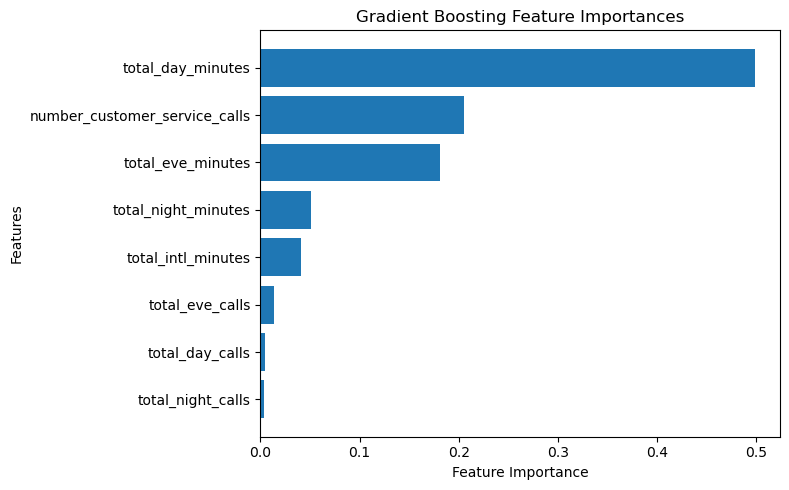

In [19]:
# Refactored using ChatGPT

## Gradient Boosting 

# 1) Load data
train_df = pd.read_csv('train.csv')

# 2) Encode churn as binary (robust to stray capitalization/whitespace)
train_df["churn_encoded"] = (
    train_df["churn"].astype(str).str.strip().str.lower().map({"no": 0, "yes": 1})
)

# 3) Select features (predictors) and target
feature_cols = [
    'total_day_minutes', 'total_eve_minutes', 'total_night_minutes',
    'total_intl_minutes', 'total_day_calls', 'total_eve_calls',
    'total_night_calls', 'number_customer_service_calls'
]
X = train_df[feature_cols].apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(train_df['churn_encoded'], errors='coerce')

# Drop rows with missing values in either X or y
mask = X.notna().all(axis=1) & y.notna()
X = X.loc[mask]
y = y.loc[mask].astype(int)

# 4) Split data (use stratify to preserve class balance when possible)
stratify_arg = y if y.value_counts().min() >= 2 and y.nunique() > 1 else None
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=stratify_arg
)

# 5) Initialize Gradient Boosting model
# - n_estimators kept moderate (500) instead of 100000 to avoid extreme runtime/overfitting
# - early stopping via validation_fraction + n_iter_no_change
gb = GradientBoostingClassifier(
    loss="log_loss",         # if using very old scikit-learn, replace with loss="deviance"
    n_estimators=500,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    random_state=20,
    validation_fraction=0.1,
    n_iter_no_change=10
)

# 6) Train
gb.fit(X_train, y_train)

# 7) Predict & Evaluate
y_pred = gb.predict(X_test)
y_prob = gb.predict_proba(X_test)[:, 1]  # needed for ROC AUC

print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"ROC AUC:  {roc_auc_score(y_test, y_prob):.3f}")
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=3))

# 8) Feature importances plot
importances = pd.Series(gb.feature_importances_, index=X_train.columns).sort_values()
plt.figure(figsize=(8, 5))
plt.barh(importances.index, importances.values)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Gradient Boosting Feature Importances")
plt.tight_layout()
plt.show()